In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from collections import defaultdict
import math
import numpy as np
from PIL import Image
import glob
from cvxopt import matrix, solvers
import random
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
import time 

Binary Classification , d = 8(ship) , d+1 = 9(truck)

In [2]:
import os
import numpy as np
from PIL import Image


In [3]:
def get_data(type = "train"):
    path = f"data/{type}/ship"
    images = [img for img in os.listdir(path) ]
    processed_images = []

    for img in images:
        image = Image.open(os.path.join(path,img)).convert("RGB")
        img_array = np.array(image).reshape(-1)
        processed_images.append(img_array)

    X_ship = np.stack(processed_images)
    Y_ship = np.array([1 for _ in range(X_ship.shape[0])])

    path = f"data/{type}/truck"
    images = [img for img in os.listdir(path) ]
    processed_images = []

    for img in images:
        image = Image.open(os.path.join(path,img)).convert("RGB")
        img_array = np.array(image).reshape(-1)
        processed_images.append(img_array)

    X_truck = np.stack(processed_images)
    Y_truck = np.array([-1 for _ in range(X_truck.shape[0])])

    X = np.vstack((X_ship, X_truck))
    X = X/255.0
    Y = np.hstack((Y_ship, Y_truck))

    return X, Y

    

In [ ]:
import cvxopt
import numpy as np

class SupportVectorMachine:
    '''
    Binary Classifier using Support Vector Machine
    '''
    def __init__(self):
        self.W = None
        self.b = None
        self.alpha = None
        self.kernel = None
        self.X_sv = None
        self.Y_sv = None
        self.alpha_sv = None
        self.alpha = None
        self.C = None
        self.gamma = None
        pass
    def linear_kernel(self, x1, x2):
        K = x1 @ x2.T
        return K
    def gaussian_kernel(self,x1,x2,gamma =0.001):
        m1 = x1.shape[0]
        m2 = x2.shape[0]
        x1_sq = np.sum(x1**2, axis=1).reshape((m1,1))
        x2_sq = np.sum(x2**2, axis=1).reshape((1,m2))
        k  =np.exp(-gamma * (x1_sq + x2_sq - 2 * (x1 @ x2.T)))
        return k
            
    def fit(self, X, y, kernel = 'linear', C = 1.0, gamma = 0.001):
        '''
        Learn the parameters from the given training data
        Classes are 0 or 1
        
        Args:
            X: np.array of shape (N, D) 
                where N is the number of samples and D is the flattened dimension of each image
                
            y: np.array of shape (N,)
                where N is the number of samples and y[i] is the class of the ith sample
                
            kernel: str
                The kernel to be used. Can be 'linear' or 'gaussian'
                
            C: float
                The regularization parameter
                
            gamma: float
                The gamma parameter for gaussian kernel, ignored for linear kernel
        '''
        self.kernel = kernel 
        self.C = C
        self.gamma = gamma
        Y = y
        t1 = time.time()
        m, n = X.shape
        K = self.linear_kernel(X, X) if kernel == 'linear' else self.gaussian_kernel(X, X, gamma=gamma)
        P = matrix(np.outer(Y, Y) * K)
        q = matrix(-np.ones(m)) 
        G = matrix(np.vstack((-np.eye(m), np.eye(m))))
        h = matrix(np.hstack((np.zeros(m), np.ones(m) * C)))
        A = matrix(Y, (1, m), 'd')
        b = matrix(0.0)
        

        sol = solvers.qp(P, q, G, h, A, b)  
        alpha = np.ravel(sol['x'])

        if kernel == 'linear':
            w = ((alpha * Y) @ X)

            

            wTx_neg = X[Y == -1] @ w
            wTx_pos = X[Y == 1] @ w

            b = - (np.max(wTx_neg) + np.min(wTx_pos)) / 2
            t2 = time.time() - t1    
            
            self.W = w
            self.b = b
            self.alpha = alpha 
        else:
            sv = alpha > 1e-5
            sv_index = np.where(sv)[0]
            print(f"number of support vectors: {len(sv_index)}")
            print(f"percentage of support vectors: {(len(sv_index)/m)*100}%")
            X_sv = X[sv]
            y_sv = Y[sv]
            alpha_sv = alpha[sv]
            t2 = time.time() - t1
            print(f"Time taken to train SVM gaussian using cvxopt: {t2} seconds")
            self.X_sv = X_sv
            self.Y_sv = y_sv
            self.alpha_sv = alpha_sv
            self.alpha = alpha
            

        

    def predict(self, X):
        '''
        Predict the class of the input data
        
        Args:
            X: np.array of shape (N, D) 
                where N is the number of samples and D is the flattened dimension of each image
                
        Returns:
            np.array of shape (N,)
                where N is the number of samples and y[i] is the class of the
                ith sample (0 or 1)
        '''
        if self.kernel == 'linear':
            ans = np.sign(X @ self.W + self.b)
        else:    
            sep_boundary = (self.alpha_sv > 1e-5) & (self.alpha_sv < self.C)
            K_boundary = self.gaussian_kernel( self.X_sv[sep_boundary],self.X_sv , self.gamma)
            b = self.Y_sv[sep_boundary] - np.sum(self.alpha_sv * self.Y_sv * K_boundary, axis=1)
            b = np.mean(b)   

            k_test = self.gaussian_kernel(X, self.X_sv, self.gamma)
            ans = k_test @ (self.alpha_sv * self.Y_sv) + b
            ans = np.sign(ans)

        ans[ans == -1] = 0
        return ans       
        
    

: 

In [5]:
def calcualte_matrices(X,Y,C=1.0):
    t1 = time.time()
    m, n = X.shape
    K = X @ X.T
    P = matrix(np.outer(Y, Y) * K)
    q = matrix(-np.ones(m)) 
    G = matrix(np.vstack((-np.eye(m), np.eye(m))))
    h = matrix(np.hstack((np.zeros(m), np.ones(m) * C)))
    A = matrix(Y, (1, m), 'd')
    b = matrix(0.0)
    

    sol = solvers.qp(P, q, G, h, A, b)  
    alpha = np.ravel(sol['x'])
    w = ((alpha * Y) @ X)

    

    wTx_neg = X[Y == -1] @ w
    wTx_pos = X[Y == 1] @ w

    b = - (np.max(wTx_neg) + np.min(wTx_pos)) / 2
    t2 = time.time() - t1    
    print(f"Time taken to train SVM linear using cvxopt: {t2} seconds")
    return w,b,alpha

def predict(X, w, b):
    return np.sign(X @ w + b)    

In [ ]:
X_train , Y_train = get_data("train")
X_test , Y_test = get_data("test")

Using b = - (np.max(wTx_neg) + np.min(wTx_pos)) / 2

In [ ]:
W_cvx_linear,b_cvx_linear,alpha_linear = calcualte_matrices(X_train,Y_train,C=1.0)
y_predictions_train = predict(X_train, W_cvx_linear, b_cvx_linear)
y_predictions_test = predict(X_test, W_cvx_linear, b_cvx_linear)

acc = accuracy_score(Y_test, y_predictions_test)
print("Test Accuracy:", acc)

acc = accuracy_score(Y_train, y_predictions_train)
print("Train Accuracy:", acc)

     pcost       dcost       gap    pres   dres
 0: -1.2014e+03 -1.0993e+04  7e+04  4e+00  1e-10
 1: -8.0102e+02 -8.2404e+03  2e+04  8e-01  1e-10
 2: -6.2036e+02 -4.0114e+03  5e+03  2e-01  8e-11
 3: -5.5668e+02 -1.3571e+03  1e+03  2e-02  8e-11
 4: -6.2158e+02 -8.9268e+02  3e+02  6e-03  8e-11
 5: -6.5908e+02 -7.7721e+02  1e+02  2e-03  8e-11
 6: -6.7695e+02 -7.2646e+02  5e+01  5e-04  8e-11
 7: -6.8706e+02 -7.0104e+02  1e+01  9e-05  8e-11
 8: -6.9011e+02 -6.9430e+02  4e+00  2e-05  8e-11
 9: -6.9124e+02 -6.9194e+02  7e-01  9e-07  9e-11
10: -6.9148e+02 -6.9153e+02  5e-02  7e-13  9e-11
11: -6.9150e+02 -6.9150e+02  2e-03  3e-13  9e-11
12: -6.9150e+02 -6.9150e+02  5e-05  6e-13  9e-11
Optimal solution found.
Test Accuracy: 0.7897897897897898
Train Accuracy: 0.9373125374925015


2.1.1

In [ ]:
sv = alpha_linear > 1e-5
number_0f_sv = np.sum(sv)
percent_sv = (number_0f_sv/len(Y_train))*100
print("Number of Support Vectors:", number_0f_sv)
print("Percentage of Support Vectors:", percent_sv)

Number of Support Vectors: 1286
Percentage of Support Vectors: 38.57228554289142


2.1.3

In [ ]:
sv_index = np.where(sv)[0]
sv_alpha = alpha_linear[sv]
top5_index = sv_index[np.argsort(-sv_alpha)[:5]]
top5_images = X_train[top5_index].reshape(-1,32,32,3)
w_images = W_cvx_linear.reshape(32,32,3)


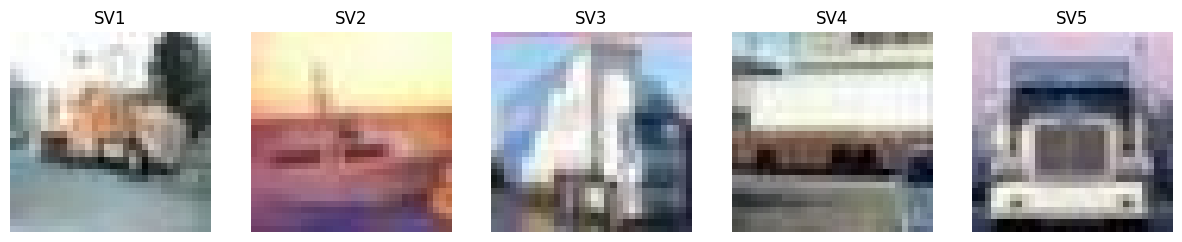

In [51]:
plt.figure(figsize=(15,3))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(top5_images[i])
    plt.axis('off')
    plt.title(f"SV{i+1}")
plt.show() 
   

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.1790218404461177].


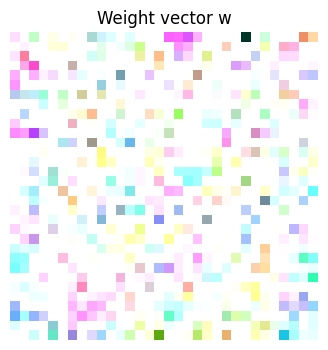

In [55]:
plt.figure(figsize=(4,4))
plt.imshow(w_images - w_images.min())  # normalize for visualization
plt.axis('off')
plt.title("Weight vector w")
plt.show()

2.2 Using Gaussian 

In [ ]:
def gaussian_kernel(x1,x2,gamma =0.001):
    m1 = x1.shape[0]
    m2 = x2.shape[0]
    x1_sq = np.sum(x1**2, axis=1).reshape((m1,1))
    x2_sq = np.sum(x2**2, axis=1).reshape((1,m2))
    k  =np.exp(-gamma * (x1_sq + x2_sq - 2 * (x1 @ x2.T)))
    return k
def calcualte_matrices_gaussian(X,Y,C=1.0):
    t1 = time.time()
    m, n = X.shape
    K = gaussian_kernel(X,X,gamma=0.001)
    P = matrix(np.outer(Y, Y) * K)
    q = matrix(-np.ones(m)) 
    G = matrix(np.vstack((-np.eye(m), np.eye(m))))
    h = matrix(np.hstack((np.zeros(m), np.ones(m) * C)))
    A = matrix(Y, (1, m), 'd')
    b = matrix(0.0)
    

    sol = solvers.qp(P, q, G, h, A, b)  
    alpha = np.ravel(sol['x'])
   

    sv = alpha > 1e-5
    sv_index = np.where(sv)[0]
    print(f"number of support vectors: {len(sv_index)}")
    print(f"percentage of support vectors: {(len(sv_index)/m)*100}%")
    X_sv = X[sv]
    y_sv = Y[sv]
    alpha_sv = alpha[sv]
    t2 = time.time() - t1
    print(f"Time taken to train SVM gaussian using cvxopt: {t2} seconds")
    return X_sv , y_sv ,alpha_sv, alpha 
   


def predict_gaussian(X_sv, y_sv, alpha_sv , X_test ,gamma = 0.001 ,C = 1.0):
    sep_boundary = (alpha_sv > 1e-5) & (alpha_sv < C)
    K_boundary = gaussian_kernel( X_sv[sep_boundary],X_sv , gamma)
    b = y_sv[sep_boundary] - np.sum(alpha_sv * y_sv * K_boundary, axis=1)
    b = np.mean(b)   

    k_test = gaussian_kernel(X_test, X_sv, gamma)
    y_predict = k_test @ (alpha_sv * y_sv) + b 
    print(y_predict)
    return np.sign(y_predict)
       


In [ ]:

X_sv, y_sv, alpha_sv, alpha_gaussian = calcualte_matrices_gaussian(X_train, Y_train, C=1.0)

y_pred = predict_gaussian(X_sv, y_sv, alpha_sv, X_test, gamma=0.001, C=1.0)


accuracy = np.mean(y_pred == Y_test)
print("Test Accuracy:", accuracy)



     pcost       dcost       gap    pres   dres
 0: -1.5427e+03 -9.2210e+03  5e+04  3e+00  1e-13
 1: -1.0917e+03 -6.5194e+03  8e+03  3e-01  1e-13
 2: -1.1360e+03 -1.9449e+03  9e+02  2e-02  1e-13
 3: -1.3170e+03 -1.6700e+03  4e+02  6e-03  1e-13
 4: -1.3950e+03 -1.5585e+03  2e+02  2e-03  1e-13
 5: -1.4363e+03 -1.5022e+03  7e+01  8e-04  1e-13
 6: -1.4556e+03 -1.4768e+03  2e+01  2e-04  2e-13
 7: -1.4633e+03 -1.4670e+03  4e+00  2e-05  2e-13
 8: -1.4648e+03 -1.4651e+03  3e-01  1e-06  2e-13
 9: -1.4650e+03 -1.4650e+03  1e-02  4e-08  2e-13
10: -1.4650e+03 -1.4650e+03  3e-04  1e-09  2e-13
Optimal solution found.
number of support vectors: 1811
percentage of support vectors: 54.31913617276545%
Test Accuracy: 0.8573573573573574


Number off matching support vectors 

In [104]:
sv_linear_cvxopt = np.where(alpha_linear > 1e-5)[0]
sv_gaussian_cvxopt = np.where(alpha_gaussian > 1e-5)[0]
X_sv_linear = X_train[sv_linear_cvxopt]
X_sv_gaussian = X_train[sv_gaussian_cvxopt]

In [105]:


match = 0
for x in X_sv_linear:
    if   np.any(np.linalg.norm(X_sv_gaussian - x, axis=1) < 1e-5):
        match += 1

print("Number of matching support vectors:", match)
print("percentage of matching support vectors:", (match/len(sv_linear_cvxopt))*100)
 

Number of matching support vectors: 1058
percentage of matching support vectors: 82.27060653188181



Top 5 images for gaussian 

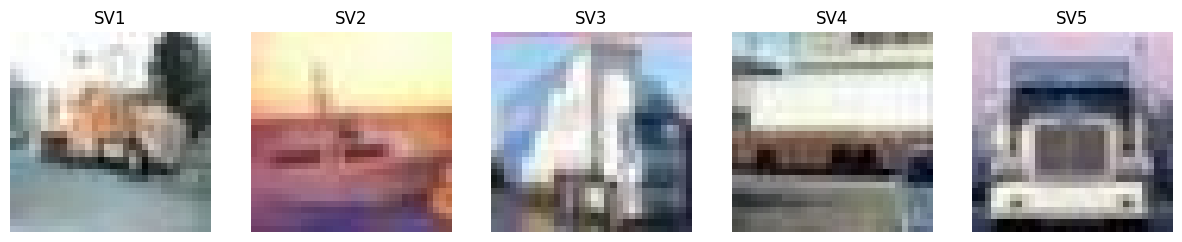

In [81]:
sv_gaussian = alpha_gaussian > 1e-5
sv_index_gaussian  = np.where(sv_gaussian)[0]
sv_alpha_gaussian = alpha_gaussian[sv_gaussian]
top5_index_gaussian = sv_index[np.argsort(-sv_alpha)[:5]]
top5_images_gaussian = X_train[top5_index_gaussian].reshape(-1,32,32,3)
plt.figure(figsize=(15,3))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(top5_images_gaussian[i])
    plt.axis('off')
    plt.title(f"SV{i+1}")
plt.show() 
   


In [101]:
sv_linear_cvxopt = np.where(alpha_linear > 1e-5)[0]
sv_gaussian_cvxopt = np.where(alpha_gaussian > 1e-5)[0]
X_sv_linear = X_train[sv_linear_cvxopt]
X_sv_gaussian = X_train[sv_gaussian_cvxopt]

Using LIBSVM

Lienar

In [85]:
t1 = time.time()
linear_svm = SVC(kernel='linear', C=1.0)
linear_svm.fit(X_train, Y_train)
t2 = time.time()
print("Time taken by LIBSVM for linear kernel:", t2 - t1)
sv_linear_svm = linear_svm.support_
print("Number of support vectors by LIBSVM (linear kernel):", len(sv_linear_svm))

Time taken by LIBSVM for linear kernel: 26.406556606292725
Number of support vectors by LIBSVM (linear kernel): 1281


Gaussian

In [86]:
t1 = time.time()
gaussian_svm = SVC(kernel='rbf', C=1.0, gamma=0.001)
gaussian_svm.fit(X_train, Y_train)
t2 = time.time()
print("Time taken by LIBSVM for Gaussian kernel:", t2 - t1)
sv_gaussian_svm = gaussian_svm.support_
print("Number of support vectors by LIBSVM (Gaussian kernel):", len(sv_gaussian_svm))


Time taken by LIBSVM for Gaussian kernel: 18.278961181640625
Number of support vectors by LIBSVM (Gaussian kernel): 1793


Support vector for cvxopt

In [96]:
print(f"number of support vector for linear kernel using cvxopt: {len(sv_linear_cvxopt)}")
print(f"number of support vector for gaussian kernel using cvxopt: {len(sv_gaussian_cvxopt)}")

number of support vector for linear kernel using cvxopt: 1286
number of support vector for gaussian kernel using cvxopt: 1811


In [107]:
def overlap(X_sv_cvx, X_sv_sklearn, tol=1e-5):
    matches = 0
    for x in X_sv_cvx:
        if np.any(np.linalg.norm(X_sv_sklearn - x, axis=1) < tol):
            matches += 1
    return matches, matches / len(X_sv_cvx)

matches_linear, frac_linear = overlap(X_sv_linear, X_train[sv_linear_svm])
matches_gaussian, frac_gaussian = overlap(X_sv_gaussian, X_train[sv_gaussian_svm])

print(f"Matching SVs (linear): {matches_linear}/{len(X_sv_linear)} ({frac_linear*100}%)")
print(f"Matching SVs (Gaussian): {matches_gaussian}/{len(X_sv_gaussian)} ({frac_gaussian*100}%)")



Matching SVs (linear): 1281/1286 (99.61119751166407%)
Matching SVs (Gaussian): 1793/1811 (99.00607399226946%)


In [110]:
w_sklearn_linear = linear_svm.coef_.ravel()
b_sklearn_linear = linear_svm.intercept_[0]

print(f"W for sklearn linear svm is {w_sklearn_linear} , and b for sklearn linear svm is {b_sklearn_linear}")
print(f"W for cvxopt linear svm is {W_cvx_linear} , and b for cvxopt linear svm is {b_cvx_linear}")


W for sklearn linear svm is [-0.05345128 -0.3446688  -0.00366444 ... -0.30131921  0.16776606
  0.14303213] , and b for sklearn linear svm is -2.054585483154745
W for cvxopt linear svm is [-0.05317856 -0.34416779 -0.00271731 ... -0.3014217   0.16815575
  0.14301236] , and b for cvxopt linear svm is -2.290540054964408


In [ ]:
print(f"Difference in W (linear): {np.linalg.norm(w_sklearn_linear - W_cvx_linear)}")

Accuracy for SVMs

In [112]:
Y_prediction_sklear_linear = linear_svm.predict(X_test)
Y_predictions_sklearn_gaussian = gaussian_svm.predict(X_test)
accuracy_sklearn_linear = accuracy_score(Y_test, Y_prediction_sklear_linear)
accuracy_sklearn_gaussian = accuracy_score(Y_test, Y_predictions_sklearn_gaussian)
print(f"Accuracy for sklearn linear svm is {accuracy_sklearn_linear * 100}")
print(f"Accuracy for sklearn gaussian svm is {accuracy_sklearn_gaussian * 100}")
                        

Accuracy for sklearn linear svm is 79.12912912912913
Accuracy for sklearn gaussian svm is 86.18618618618619


In [ ]:
def gaussian_kernel(x1,x2,gamma =0.001):
    m1 = x1.shape[0]
    m2 = x2.shape[0]
    x1_sq = np.sum(x1**2, axis=1).reshape((m1,1))
    x2_sq = np.sum(x2**2, axis=1).reshape((1,m2))
    k  =np.exp(-gamma * (x1_sq + x2_sq - 2 * (x1 @ x2.T)))
    return k
def calcualte_matrices_gaussian(X,Y,C=1.0):
    t1 = time.time()
    m, n = X.shape
    K = gaussian_kernel(X,X,gamma=0.001)
    P = matrix(np.outer(Y, Y) * K)
    q = matrix(-np.ones(m)) 
    G = matrix(np.vstack((-np.eye(m), np.eye(m))))
    h = matrix(np.hstack((np.zeros(m), np.ones(m) * C)))
    A = matrix(Y, (1, m), 'd')
    b = matrix(0.0)
    

    sol = solvers.qp(P, q, G, h, A, b)  
    alpha = np.ravel(sol['x'])
   

    sv = alpha > 1e-5
    sv_index = np.where(sv)[0]
    print(f"number of support vectors: {len(sv_index)}")
    print(f"percentage of support vectors: {(len(sv_index)/m)*100}%")
    X_sv = X[sv]
    y_sv = Y[sv]
    alpha_sv = alpha[sv]
    t2 = time.time() - t1
    print(f"Time taken to train SVM gaussian using cvxopt: {t2} seconds")
    return X_sv , y_sv ,alpha_sv, alpha 
   


def predict_gaussian(X_sv, y_sv, alpha_sv , X_test ,gamma = 0.001 ,C = 1.0):
    sep_boundary = (alpha_sv > 1e-5) & (alpha_sv < C)
    K_boundary = gaussian_kernel( X_sv[sep_boundary],X_sv , gamma)
    b = y_sv[sep_boundary] - np.sum(alpha_sv * y_sv * K_boundary, axis=1)
    b = np.mean(b)   

    k_test = gaussian_kernel(X_test, X_sv, gamma)
    y_predict = k_test @ (alpha_sv * y_sv) + b 
    return np.sign(y_predict)
       

In [119]:
def get_data(type = "train", labels = ["ship" , "truck"]):
    path = f"data/{type}/{labels[0]}"
    images = [img for img in os.listdir(path) ]
    processed_images = []

    for img in images:
        image = Image.open(os.path.join(path,img)).convert("RGB")
        img_array = np.array(image).reshape(-1)
        processed_images.append(img_array)

    X_ship = np.stack(processed_images)
    Y_ship = np.array([1 for _ in range(X_ship.shape[0])])

    path = f"data/{type}/{labels[1]}"
    images = [img for img in os.listdir(path) ]
    processed_images = []

    for img in images:
        image = Image.open(os.path.join(path,img)).convert("RGB")
        img_array = np.array(image).reshape(-1)
        processed_images.append(img_array)

    X_truck = np.stack(processed_images)
    Y_truck = np.array([-1 for _ in range(X_truck.shape[0])])

    X = np.vstack((X_ship, X_truck))
    X = X/255.0
    Y = np.hstack((Y_ship, Y_truck))

    return X, Y

    


In [121]:
list_of_labels = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

        


In [ ]:

x_store = []
y_store = []

for i in range(len(list_of_labels)):
    label = list_of_labels[i]
    path = f"data/test/{label}"
    images = [img for img in os.listdir(path) ]
    processed_images = []

    for img in images:
        image = Image.open(os.path.join(path,img)).convert("RGB")
        img_array = np.array(image).reshape(-1)
        processed_images.append(img_array)

    X_ship = np.stack(processed_images)
    Y_ship = np.array([i for _ in range(X_ship.shape[0])])
    x_store.append(X_ship)
    y_store.append(Y_ship)

X_test_multi = np.vstack(x_store)
Y_test_multi = np.hstack(y_store)

In [123]:

clssifier_pair = {}

for i in range(len(list_of_labels)-1):
    for j in range(i+1, len(list_of_labels)):
        label_pair = (list_of_labels[i], list_of_labels[j])


        X_train, Y_train = get_data("train", labels=list(label_pair))
        
        X_sv, y_sv, alpha_sv, alpha_gaussian = calcualte_matrices_gaussian(X_train, Y_train, C=1.0)
        clssifier_pair[label_pair] = (X_sv, y_sv, alpha_sv)
        



        

MemoryError: Unable to allocate 84.8 MiB for an array with shape (3334, 3334) and data type float64